In [1]:
# Monte Carlo Portfolio Stress Testing
# Salkun stressitestaus Monte Carlo -simulaatiolla

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, t as student_t
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Matplotlib asetukset
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Kirjastot ladattu onnistuneesti!")

✅ Kirjastot ladattu onnistuneesti!


In [2]:
class MonteCarloStressTester:
    def __init__(self):
        self.portfolio_data = None
        self.returns_data = None
        self.correlation_matrix = None
        self.volatilities = None
        self.weights = None
        self.portfolio_value = 1000000  # 1M€ portfolio
        self.tickers = None
        self.simulation_results = None
        self.stress_results = None
print("🎲 MonteCarloStressTester luotu!")

🎲 MonteCarloStressTester luotu!


In [3]:
def fetch_portfolio_data(self, tickers, weights, start_date='2020-01-01', end_date='2024-01-01'):
    """Haetaan salkun historiallista dataa"""
    print("📈 Haetaan portfolion historiallista dataa...")
    
    self.tickers = tickers
    self.weights = np.array(weights)
    
    # Varmistetaan että painot summautuvat 1:een
    self.weights = self.weights / self.weights.sum()
    
    # Haetaan hintadata
    data = {}
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if hasattr(stock_data.columns, 'levels'):
                # MultiIndex sarakkeet
                for col in stock_data.columns:
                    if col[0] in ['Adj Close', 'Close']:
                        data[ticker] = stock_data[col]
                        break
            else:
                if 'Adj Close' in stock_data.columns:
                    data[ticker] = stock_data['Adj Close']
                elif 'Close' in stock_data.columns:
                    data[ticker] = stock_data['Close']
                    
            print(f"✓ {ticker}: {len(data[ticker])} päivää")
        except Exception as e:
            print(f"✗ {ticker}: {e}")
    
    # Luodaan DataFrame ja lasketaan tuotot
    self.portfolio_data = pd.DataFrame(data).dropna()
    self.returns_data = self.portfolio_data.pct_change().dropna()
    
    # Lasketaan korrelaatiomatriisi ja volatiliteetit
    self.correlation_matrix = self.returns_data.corr()
    self.volatilities = self.returns_data.std() * np.sqrt(252)  # Vuosivolatiliteetti
    
    print(f"\n📊 Portfolio ladattu:")
    print(f"   Omistukset: {len(self.tickers)}")
    print(f"   Historiallinen data: {len(self.returns_data)} päivää")
    print(f"   Salkun arvo: {self.portfolio_value:,.0f}€")
    
    return self.portfolio_data

MonteCarloStressTester.fetch_portfolio_data = fetch_portfolio_data

In [4]:
def historical_portfolio_metrics(self):
    """Lasketaan salkun historialliset mittarit"""
    print("\n📊 HISTORIALLINEN PORTFOLIO-ANALYYSI:")
    print("-" * 50)
    
    # Päivittäiset portfolio-tuotot
    daily_portfolio_returns = (self.returns_data * self.weights).sum(axis=1)
    
    # Vuosimittarit
    annual_return = daily_portfolio_returns.mean() * 252
    annual_volatility = daily_portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    
    # Riskimittarit
    var_95 = np.percentile(daily_portfolio_returns, 5)
    var_99 = np.percentile(daily_portfolio_returns, 1)
    max_drawdown = self._calculate_max_drawdown(daily_portfolio_returns)
    
    print(f"Vuosituotto (keskiarvo): {annual_return:.2%}")
    print(f"Vuosivolatiliteetti: {annual_volatility:.2%}")
    print(f"Sharpe-suhde: {sharpe_ratio:.3f}")
    print(f"VaR (95%): {var_95:.2%} päivässä")
    print(f"VaR (99%): {var_99:.2%} päivässä")
    print(f"Maksimipudotus: {max_drawdown:.2%}")
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'var_95': var_95,
        'var_99': var_99,
        'max_drawdown': max_drawdown
    }

def _calculate_max_drawdown(self, returns):
    """Laske maksimipudotus"""
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    return drawdown.min()

MonteCarloStressTester.historical_portfolio_metrics = historical_portfolio_metrics
MonteCarloStressTester._calculate_max_drawdown = _calculate_max_drawdown

In [5]:
def monte_carlo_simulation(self, n_simulations=10000, time_horizon=252, 
                          distribution='normal', confidence_levels=[95, 99, 99.9]):
    """Suoritetaan Monte Carlo -simulaatio portfoliolle"""
    print(f"\n🎲 MONTE CARLO SIMULAATIO:")
    print(f"   Simulaatioita: {n_simulations:,}")
    print(f"   Aikahoristontti: {time_horizon} päivää")
    print(f"   Jakauma: {distribution}")
    print("-" * 50)
    
    # Historiallisten tuottojen parametrit
    mean_returns = self.returns_data.mean().values
    cov_matrix = self.returns_data.cov().values
    
    # Tallennetaan simulaatiotulokset
    portfolio_final_values = []
    portfolio_returns_paths = []
    min_values_during_path = []
    
    for sim in range(n_simulations):
        if sim % 2000 == 0:
            print(f"Simulaatio {sim:,}/{n_simulations:,}")
        
        # Generoidaan satunnaistuottoja
        if distribution == 'normal':
            random_returns = np.random.multivariate_normal(mean_returns, cov_matrix, time_horizon)
        elif distribution == 't_distribution':
            # t-jakauma (raskaammät hännät = enemmän äärimmäisiä liikkeitä)
            df = 5  # vapausasteet
            random_returns = multivariate_normal.rvs(mean_returns, cov_matrix, time_horizon)
            # Skaalataan t-jakaumalla
            t_multipliers = student_t.rvs(df, size=(time_horizon, len(mean_returns))) / np.sqrt(df/(df-2))
            random_returns = random_returns * t_multipliers
        
        # Lasketaan portfolio-tuotot
        portfolio_returns = np.sum(random_returns * self.weights, axis=1)
        
        # Lasketaan kumulatiivinen arvo
        portfolio_values = self.portfolio_value * np.cumprod(1 + portfolio_returns)
        
        # Tallennetaan tulokset
        portfolio_final_values.append(portfolio_values[-1])
        portfolio_returns_paths.append(portfolio_returns)
        min_values_during_path.append(portfolio_values.min())
    
    self.simulation_results = {
        'final_values': np.array(portfolio_final_values),
        'returns_paths': portfolio_returns_paths,
        'min_values': np.array(min_values_during_path),
        'initial_value': self.portfolio_value,
        'time_horizon': time_horizon,
        'n_simulations': n_simulations
    }
    
    # Analysoidaan tulokset
    self._analyze_simulation_results(confidence_levels)
    
    return self.simulation_results

MonteCarloStressTester.monte_carlo_simulation = monte_carlo_simulation

In [6]:
def _analyze_simulation_results(self, confidence_levels):
    """Analysoidaan Monte Carlo -tulokset"""
    final_values = self.simulation_results['final_values']
    min_values = self.simulation_results['min_values']
    initial_value = self.simulation_results['initial_value']
    
    print("\n📊 SIMULAATIOTULOKSET:")
    print("-" * 50)
    
    # Perusstatistiikka
    mean_final_value = np.mean(final_values)
    median_final_value = np.median(final_values)
    
    print(f"Alkuarvo: {initial_value:,.0f}€")
    print(f"Keskimääräinen loppuarvo: {mean_final_value:,.0f}€")
    print(f"Mediaani loppuarvo: {median_final_value:,.0f}€")
    print(f"Odotettu tuotto: {(mean_final_value/initial_value - 1)*100:.1f}%")
    
    # Value at Risk (VaR) analyysi
    print(f"\n💰 VALUE AT RISK (VaR):")
    for conf in confidence_levels:
        percentile = 100 - conf
        var_value = np.percentile(final_values, percentile)
        var_loss = initial_value - var_value
        var_pct = (var_loss / initial_value) * 100
        
        print(f"VaR {conf}%: {var_loss:,.0f}€ ({var_pct:.1f}%) - Arvo: {var_value:,.0f}€")
    
    # Expected Shortfall (CVaR)
    print(f"\n🔻 EXPECTED SHORTFALL (CVaR):")
    for conf in confidence_levels:
        percentile = 100 - conf
        var_threshold = np.percentile(final_values, percentile)
        tail_values = final_values[final_values <= var_threshold]
        if len(tail_values) > 0:
            cvar_value = np.mean(tail_values)
            cvar_loss = initial_value - cvar_value
            cvar_pct = (cvar_loss / initial_value) * 100
            print(f"CVaR {conf}%: {cvar_loss:,.0f}€ ({cvar_pct:.1f}%) - Keskiarvo: {cvar_value:,.0f}€")
    
    # Maksimispudotusanalyysi
    max_potential_loss = initial_value - np.min(min_values)
    max_loss_pct = (max_potential_loss / initial_value) * 100
    
    print(f"\n📉 MAKSIMIPUDOTUS:")
    print(f"Suurin mahdollinen tappio matkan varrella: {max_potential_loss:,.0f}€ ({max_loss_pct:.1f}%)")
    
    # Positiivisten tuottojen todennäköisyys
    prob_positive = np.mean(final_values > initial_value) * 100
    prob_loss_over_20 = np.mean(final_values < initial_value * 0.8) * 100
    prob_loss_over_50 = np.mean(final_values < initial_value * 0.5) * 100
    
    print(f"\n🎯 TODENNÄKÖISYYDET:")
    print(f"Positiivinen tuotto: {prob_positive:.1f}%")
    print(f"Tappio yli 20%: {prob_loss_over_20:.1f}%")
    print(f"Tappio yli 50%: {prob_loss_over_50:.1f}%")

MonteCarloStressTester._analyze_simulation_results = _analyze_simulation_results

In [7]:
def stress_scenarios(self):
    """Suorita stressitestejä historiallisiin kriiseihin perustuen"""
    print("\n⚡ STRESSISKENAARIO-ANALYYSI:")
    print("-" * 50)
    
    # Määritellään stressiskenaariot (päivittäiset shokit)
    stress_scenarios = {
        'Black Monday 1987': {'market_shock': -0.20, 'correlation_increase': 0.3},
        'Dotcom Crash 2000': {'market_shock': -0.12, 'correlation_increase': 0.25},
        'Financial Crisis 2008': {'market_shock': -0.15, 'correlation_increase': 0.4},
        'COVID-19 Crash 2020': {'market_shock': -0.12, 'correlation_increase': 0.35},
        'Flash Crash 2010': {'market_shock': -0.08, 'correlation_increase': 0.2},
        'Mild Recession': {'market_shock': -0.05, 'correlation_increase': 0.15},
        'Severe Recession': {'market_shock': -0.25, 'correlation_increase': 0.5}
    }
    
    scenario_results = {}
    
    for scenario_name, params in stress_scenarios.items():
        print(f"\n📊 Skenaario: {scenario_name}")
        
        # Simuloidaan skenaario
        market_shock = params['market_shock']
        corr_increase = params['correlation_increase']
        
        # Luodaan stressikorrelaatiomatriisi
        stress_corr = self.correlation_matrix.copy()
        # Nosta korrelaatioita (kriisissä kaikki liikkuu samaan suuntaan)
        mask = ~np.eye(stress_corr.shape[0], dtype=bool)
        stress_corr.values[mask] = np.clip(stress_corr.values[mask] + corr_increase, -1, 1)
        
        # Stressivolatiliteetit (kriisityyppisellä stressillä)
        stress_vols = self.volatilities * (1 + abs(market_shock) * 2)
        
        # Muunnetaan korrelaatiomatriisi kovarianssiksi
        stress_cov = np.outer(stress_vols, stress_vols) * stress_corr.values
        
        # Simuloidaan stressiskenaario (30 päivää)
        n_sims = 5000
        stress_results = []
        
        for _ in range(n_sims):
            # Generoidaan 30 päivän tuottosarja stressissä
            stress_returns = np.random.multivariate_normal(
                np.full(len(self.tickers), market_shock/30),  # Jaettu 30 päivälle
                stress_cov / 252,  # Päivittäinen kovarianssi
                30
            )
            
            # Portfolio-tuotto
            portfolio_returns = np.sum(stress_returns * self.weights, axis=1)
            final_value = self.portfolio_value * np.prod(1 + portfolio_returns)
            stress_results.append(final_value)
        
        stress_results = np.array(stress_results)
        
        # Analysoidaan tulokset
        mean_value = np.mean(stress_results)
        var_95 = np.percentile(stress_results, 5)
        var_99 = np.percentile(stress_results, 1)
        worst_case = np.min(stress_results)
        
        mean_loss = self.portfolio_value - mean_value
        var_95_loss = self.portfolio_value - var_95
        var_99_loss = self.portfolio_value - var_99
        worst_loss = self.portfolio_value - worst_case
        
        print(f"   Keskimääräinen tappio: {mean_loss:,.0f}€ ({mean_loss/self.portfolio_value*100:.1f}%)")
        print(f"   VaR 95%: {var_95_loss:,.0f}€ ({var_95_loss/self.portfolio_value*100:.1f}%)")
        print(f"   VaR 99%: {var_99_loss:,.0f}€ ({var_99_loss/self.portfolio_value*100:.1f}%)")
        print(f"   Worst case: {worst_loss:,.0f}€ ({worst_loss/self.portfolio_value*100:.1f}%)")
        
        scenario_results[scenario_name] = {
            'mean_loss': mean_loss,
            'var_95_loss': var_95_loss,
            'var_99_loss': var_99_loss,
            'worst_loss': worst_loss,
            'final_values': stress_results
        }
    
    self.stress_results = scenario_results
    return scenario_results

MonteCarloStressTester.stress_scenarios = stress_scenarios

In [8]:
def create_basic_visualizations(self):
    """Luodaan perusvisualisoinnit"""
    print("\n📊 Luodaan perusvisualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Portfolio-painojakauma
    colors = plt.cm.Set3(np.linspace(0, 1, len(self.tickers)))
    axes[0,0].pie(self.weights, labels=self.tickers, autopct='%1.1f%%', colors=colors)
    axes[0,0].set_title('Portfolio-jakauma', fontsize=14, fontweight='bold')
    
    # 2. Historiallinen korrelaatiomatriisi
    sns.heatmap(self.correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
               square=True, ax=axes[0,1], fmt='.2f')
    axes[0,1].set_title('Historiallinen korrelaatiomatriisi', fontsize=14, fontweight='bold')
    
    # 3. Historiallisten tuottojen jakauma
    portfolio_returns = (self.returns_data * self.weights).sum(axis=1)
    axes[1,0].hist(portfolio_returns, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[1,0].axvline(portfolio_returns.mean(), color='red', linestyle='--', 
                     label=f'Keskiarvo: {portfolio_returns.mean():.3f}')
    axes[1,0].set_title('Historiallisten päivittäisten tuottojen jakauma', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Päivittäinen tuotto')
    axes[1,0].set_ylabel('Frekvenssi')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Kumulatiivinen tuotto
    cumulative_returns = (1 + portfolio_returns).cumprod()
    axes[1,1].plot(cumulative_returns.index, cumulative_returns, linewidth=2)
    axes[1,1].set_title('Historiallinen kumulatiivinen tuotto', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Päivämäärä')
    axes[1,1].set_ylabel('Kumulatiivinen tuotto')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

MonteCarloStressTester.create_basic_visualizations = create_basic_visualizations

In [9]:
def create_monte_carlo_visualizations(self):
    """Luodaan Monte Carlo tulosten visualisoinnit"""
    if not hasattr(self, 'simulation_results') or self.simulation_results is None:
        print("❌ Monte Carlo simulaatiota ei ole suoritettu!")
        return
    
    print("\n📊 Luodaan Monte Carlo visualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    final_values = self.simulation_results['final_values']
    
    # 1. Monte Carlo -tulosten jakauma
    axes[0,0].hist(final_values, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(self.portfolio_value, color='red', linestyle='--', 
                     label=f'Alkuarvo: {self.portfolio_value:,.0f}€')
    axes[0,0].axvline(np.mean(final_values), color='green', linestyle='--',
                     label=f'Keskiarvo: {np.mean(final_values):,.0f}€')
    axes[0,0].axvline(np.percentile(final_values, 5), color='orange', linestyle='--',
                     label=f'VaR 95%: {np.percentile(final_values, 5):,.0f}€')
    
    axes[0,0].set_title('Monte Carlo: Portfolio-arvojen jakauma', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Portfolio-arvo (€)')
    axes[0,0].set_ylabel('Frekvenssi')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. VaR-vertailu eri luottamustasoilla
    confidence_levels = [90, 95, 99, 99.5, 99.9]
    var_values = []
    
    for conf in confidence_levels:
        percentile = 100 - conf
        var_value = np.percentile(final_values, percentile)
        var_loss = self.portfolio_value - var_value
        var_values.append(var_loss)
    
    axes[0,1].plot(confidence_levels, var_values, 'bo-', linewidth=2, markersize=8)
    axes[0,1].set_title('VaR eri luottamustasoilla', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Luottamustaso (%)')
    axes[0,1].set_ylabel('VaR (€)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Lisätään arvot pisteisiin
    for x, y in zip(confidence_levels, var_values):
        axes[0,1].text(x, y + max(var_values)*0.02, f'{y:,.0f}€', 
                      ha='center', va='bottom', fontsize=9)
    
    # 3. Simulaatiopolkujen näyte
    sample_paths = np.random.choice(len(self.simulation_results['returns_paths']), 100, replace=False)
    
    for i in sample_paths:
        returns_path = self.simulation_results['returns_paths'][i]
        value_path = self.portfolio_value * np.cumprod(1 + returns_path)
        axes[1,0].plot(value_path, alpha=0.1, color='blue')
    
    # Keskimääräinen polku
    mean_path = []
    for day in range(self.simulation_results['time_horizon']):
        day_returns = [path[day] for path in self.simulation_results['returns_paths']]
        mean_return = np.mean(day_returns)
        if day == 0:
            mean_path.append(self.portfolio_value * (1 + mean_return))
        else:
            mean_path.append(mean_path[-1] * (1 + mean_return))
    
    axes[1,0].plot(mean_path, color='red', linewidth=3, label='Keskimääräinen polku')
    axes[1,0].axhline(self.portfolio_value, color='black', linestyle='--', label='Alkuarvo')
    
    axes[1,0].set_title('Simulaatiopolkujen näyte (100 kpl)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Päivä')
    axes[1,0].set_ylabel('Portfolio-arvo (€)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Drawdown analyysi
    min_values = self.simulation_results['min_values']
    drawdowns = (self.portfolio_value - min_values) / self.portfolio_value * 100
    
    axes[1,1].hist(drawdowns, bins=50, alpha=0.7, color='salmon', edgecolor='black')
    axes[1,1].axvline(np.mean(drawdowns), color='red', linestyle='--',
                     label=f'Keskiarvo: {np.mean(drawdowns):.1f}%')
    axes[1,1].axvline(np.percentile(drawdowns, 95), color='orange', linestyle='--',
                     label=f'95% percentile: {np.percentile(drawdowns, 95):.1f}%')
    
    axes[1,1].set_title('Maksimipudotus jakauma', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Drawdown (%)')
    axes[1,1].set_ylabel('Frekvenssi')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

MonteCarloStressTester.create_monte_carlo_visualizations = create_monte_carlo_visualizations

In [10]:
def create_stress_visualizations(self):
    """Luo stressitestien visualisoinnit"""
    if not hasattr(self, 'stress_results') or self.stress_results is None:
        print("❌ Stressitestejä ei ole suoritettu!")
        return
    
    print("\n📊 Luodaan stressitesti visualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Stressiskenaarioiden VaR 95% vertailu
    scenarios = list(self.stress_results.keys())
    var_95_losses = [self.stress_results[s]['var_95_loss'] for s in scenarios]
    
    bars = axes[0,0].barh(scenarios, var_95_losses, color='red', alpha=0.7)
    axes[0,0].set_title('Stressiskenaariot: VaR 95% tappiot', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Tappio (€)')
    
    # Lisätään arvot pylväiden viereen
    for bar, value in zip(bars, var_95_losses):
        axes[0,0].text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
                      f'{value:,.0f}€', ha='left', va='center')
    
    # 2. Stressiskenaarioiden VaR 99% vertailu
    var_99_losses = [self.stress_results[s]['var_99_loss'] for s in scenarios]
    
    bars = axes[0,1].barh(scenarios, var_99_losses, color='darkred', alpha=0.7)
    axes[0,1].set_title('Stressiskenaariot: VaR 99% tappiot', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Tappio (€)')
    
    for bar, value in zip(bars, var_99_losses):
        axes[0,1].text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
                      f'{value:,.0f}€', ha='left', va='center')
    
    # 3. Stressiskenaarioiden worst case vertailu
    worst_losses = [self.stress_results[s]['worst_loss'] for s in scenarios]
    
    bars = axes[1,0].barh(scenarios, worst_losses, color='maroon', alpha=0.7)
    axes[1,0].set_title('Stressiskenaariot: Worst Case tappiot', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Tappio (€)')
    
    for bar, value in zip(bars, worst_losses):
        axes[1,0].text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
                      f'{value:,.0f}€', ha='left', va='center')
    
    # 4. Stressiskenaarioiden tappioiden vertailu (% muodossa)
    var_95_pct = [(loss/self.portfolio_value)*100 for loss in var_95_losses]
    var_99_pct = [(loss/self.portfolio_value)*100 for loss in var_99_losses]
    worst_pct = [(loss/self.portfolio_value)*100 for loss in worst_losses]
    
    x = np.arange(len(scenarios))
    width = 0.25
    
    axes[1,1].bar(x - width, var_95_pct, width, label='VaR 95%', color='orange', alpha=0.7)
    axes[1,1].bar(x, var_99_pct, width, label='VaR 99%', color='red', alpha=0.7)
    axes[1,1].bar(x + width, worst_pct, width, label='Worst Case', color='maroon', alpha=0.7)
    
    axes[1,1].set_title('Stressiskenaariot: Tappiot prosentteina', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Skenaariot')
    axes[1,1].set_ylabel('Tappio (%)')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(scenarios, rotation=45, ha='right')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

MonteCarloStressTester.create_stress_visualizations = create_stress_visualizations

In [11]:
def generate_risk_report(self):
    """Luodaan kattava riskiraportti"""
    print("\n" + "="*80)
    print("📋 MONTE CARLO STRESS TESTING - RISKIRAPORTTI")
    print("="*80)
    
    print(f"\n🎯 PORTFOLIO-YLEISKATSAUS:")
    print(f"Portfolio-arvo: {self.portfolio_value:,.0f}€")
    print(f"Osakkeet: {', '.join(self.tickers)}")
    print(f"Painotus: {', '.join([f'{w:.1%}' for w in self.weights])}")
    
    if hasattr(self, 'simulation_results') and self.simulation_results is not None:
        final_values = self.simulation_results['final_values']
        
        print(f"\n📊 MONTE CARLO TULOKSET ({self.simulation_results['n_simulations']:,} simulaatiota):")
        print(f"Aikahoristontti: {self.simulation_results['time_horizon']} päivää")
        print(f"Odotettu tuotto: {(np.mean(final_values)/self.portfolio_value - 1)*100:.1f}%")
        print(f"Volatiliteetti: {np.std(final_values)/self.portfolio_value*100:.1f}%")
        
        # VaR-yhteenveto
        var_95_loss = self.portfolio_value - np.percentile(final_values, 5)
        var_99_loss = self.portfolio_value - np.percentile(final_values, 1)
        
        print(f"\n💰 RISKIMITTARIT:")
        print(f"VaR 95% (1 vuosi): {var_95_loss:,.0f}€ ({var_95_loss/self.portfolio_value*100:.1f}%)")
        print(f"VaR 99% (1 vuosi): {var_99_loss:,.0f}€ ({var_99_loss/self.portfolio_value*100:.1f}%)")
        
        # Expected Shortfall
        es_95 = np.mean(final_values[final_values <= np.percentile(final_values, 5)])
        es_95_loss = self.portfolio_value - es_95
        print(f"Expected Shortfall 95%: {es_95_loss:,.0f}€ ({es_95_loss/self.portfolio_value*100:.1f}%)")
    
    if hasattr(self, 'stress_results') and self.stress_results is not None:
        print(f"\n⚡ STRESSITESTI-YHTEENVETO:")
        print("-" * 50)
        
        for scenario, results in self.stress_results.items():
            var_loss = results['var_95_loss']
            print(f"{scenario:25}: {var_loss:8,.0f}€ ({var_loss/self.portfolio_value*100:5.1f}%)")
    
    print(f"\n🎯 SUOSITUKSET:")
    if hasattr(self, 'simulation_results') and self.simulation_results is not None:
        final_values = self.simulation_results['final_values']
        var_95_loss = self.portfolio_value - np.percentile(final_values, 5)
        var_95_pct = var_95_loss/self.portfolio_value
        
        if var_95_pct > 0.25:
            print("🔴 KORKEA RISKI: Portfolio on erittäin riskialtis")
            print("   → Harkitse hajautuksen lisäämistä")
            print("   → Vähennä riski-omaisuuksia")
        elif var_95_pct > 0.15:
            print("🟡 KOHTALAINEN RISKI: Portfolio on melko riskialtis")
            print("   → Seuraa markkinatilannetta aktiivisesti")
            print("   → Harkitse suojausstrategioita")
        else:
            print("🟢 MALTILLINEN RISKI: Portfolio-riski hallinnassa")
            print("   → Jatka nykyistä strategiaa")
    
    print(f"\n📈 REGULAATORISET NÄKÖKOHDAT:")
    print("• Basel III: VaR-malli hyväksyttävissä riskinhallintaan")
    print("• Solvency II: Stressitestit täyttävät vaatimukset")
    print("• MiFID II: Asianmukainen riskien arviointi")
    
    # Palautetaan tulokset
    results = {}
    if hasattr(self, 'simulation_results') and self.simulation_results is not None:
        final_values = self.simulation_results['final_values']
        results['var_95'] = self.portfolio_value - np.percentile(final_values, 5)
        results['var_99'] = self.portfolio_value - np.percentile(final_values, 1)
    if hasattr(self, 'stress_results'):
        results['stress_results'] = self.stress_results
    
    return results

MonteCarloStressTester.generate_risk_report = generate_risk_report

In [12]:
# testiportfolio
print("🎲 Monte Carlo Portfolio Stress Testing")
print("="*50)

# MUOKKAA PARAMETREJA:
portfolio_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
portfolio_weights = [0.25, 0.20, 0.15, 0.15, 0.15, 0.10]  # Teknologiapainotteinen

# Vaihtoehtoisesti:
# portfolio_tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM']  # ETF-salkku
# portfolio_weights = [0.4, 0.3, 0.1, 0.1, 0.1]

# stress tester
stress_tester = MonteCarloStressTester()

print(f"📊 Portfolio määritelty:")
print(f"   Osakkeet: {portfolio_tickers}")
print(f"   Painot: {portfolio_weights}")
print(f"   Salkun arvo: {stress_tester.portfolio_value:,.0f}€")

🎲 Monte Carlo Portfolio Stress Testing
📊 Portfolio määritelty:
   Osakkeet: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
   Painot: [0.25, 0.2, 0.15, 0.15, 0.15, 0.1]
   Salkun arvo: 1,000,000€


In [13]:
# 1. portfolio-data
print("\n🔄 VAIHE 1: Portfolio-datan lataus")
try:
    portfolio_data = stress_tester.fetch_portfolio_data(
        portfolio_tickers, 
        portfolio_weights,
        start_date='2020-01-01',  
        end_date='2024-01-01'   
    )
    
    # datainfo
    print(f"\n📈 Ladattu data:")
    print(portfolio_data.head())
    print(f"\nData koko: {portfolio_data.shape}")
    
except Exception as e:
    print(f"❌ Virhe datan latauksessa: {e}")


🔄 VAIHE 1: Portfolio-datan lataus
📈 Haetaan portfolion historiallista dataa...
✓ AAPL: 1006 päivää
✓ MSFT: 1006 päivää
✓ GOOGL: 1006 päivää
✓ AMZN: 1006 päivää
✓ TSLA: 1006 päivää
✓ NVDA: 1006 päivää

📊 Portfolio ladattu:
   Omistukset: 6
   Historiallinen data: 1005 päivää
   Salkun arvo: 1,000,000€

📈 Ladattu data:
                 AAPL        MSFT      GOOGL       AMZN       TSLA      NVDA
Date                                                                        
2020-01-02  72.620834  153.042297  68.026024  94.900497  28.684000  5.971746
2020-01-03  71.914810  151.136658  67.670151  93.748497  29.534000  5.876163
2020-01-06  72.487854  151.527328  69.473839  95.143997  30.102667  5.900806
2020-01-07  72.146950  150.145737  69.339645  95.343002  31.270666  5.972244
2020-01-08  73.307503  152.537323  69.833191  94.598503  32.809334  5.983447

Data koko: (1006, 6)



🔄 VAIHE 2: Historiallinen analyysi

📊 HISTORIALLINEN PORTFOLIO-ANALYYSI:
--------------------------------------------------
Vuosituotto (keskiarvo): 37.72%
Vuosivolatiliteetti: 33.69%
Sharpe-suhde: 1.120
VaR (95%): -3.49% päivässä
VaR (99%): -5.16% päivässä
Maksimipudotus: -44.64%

📊 Luodaan perusvisualisoinnit...


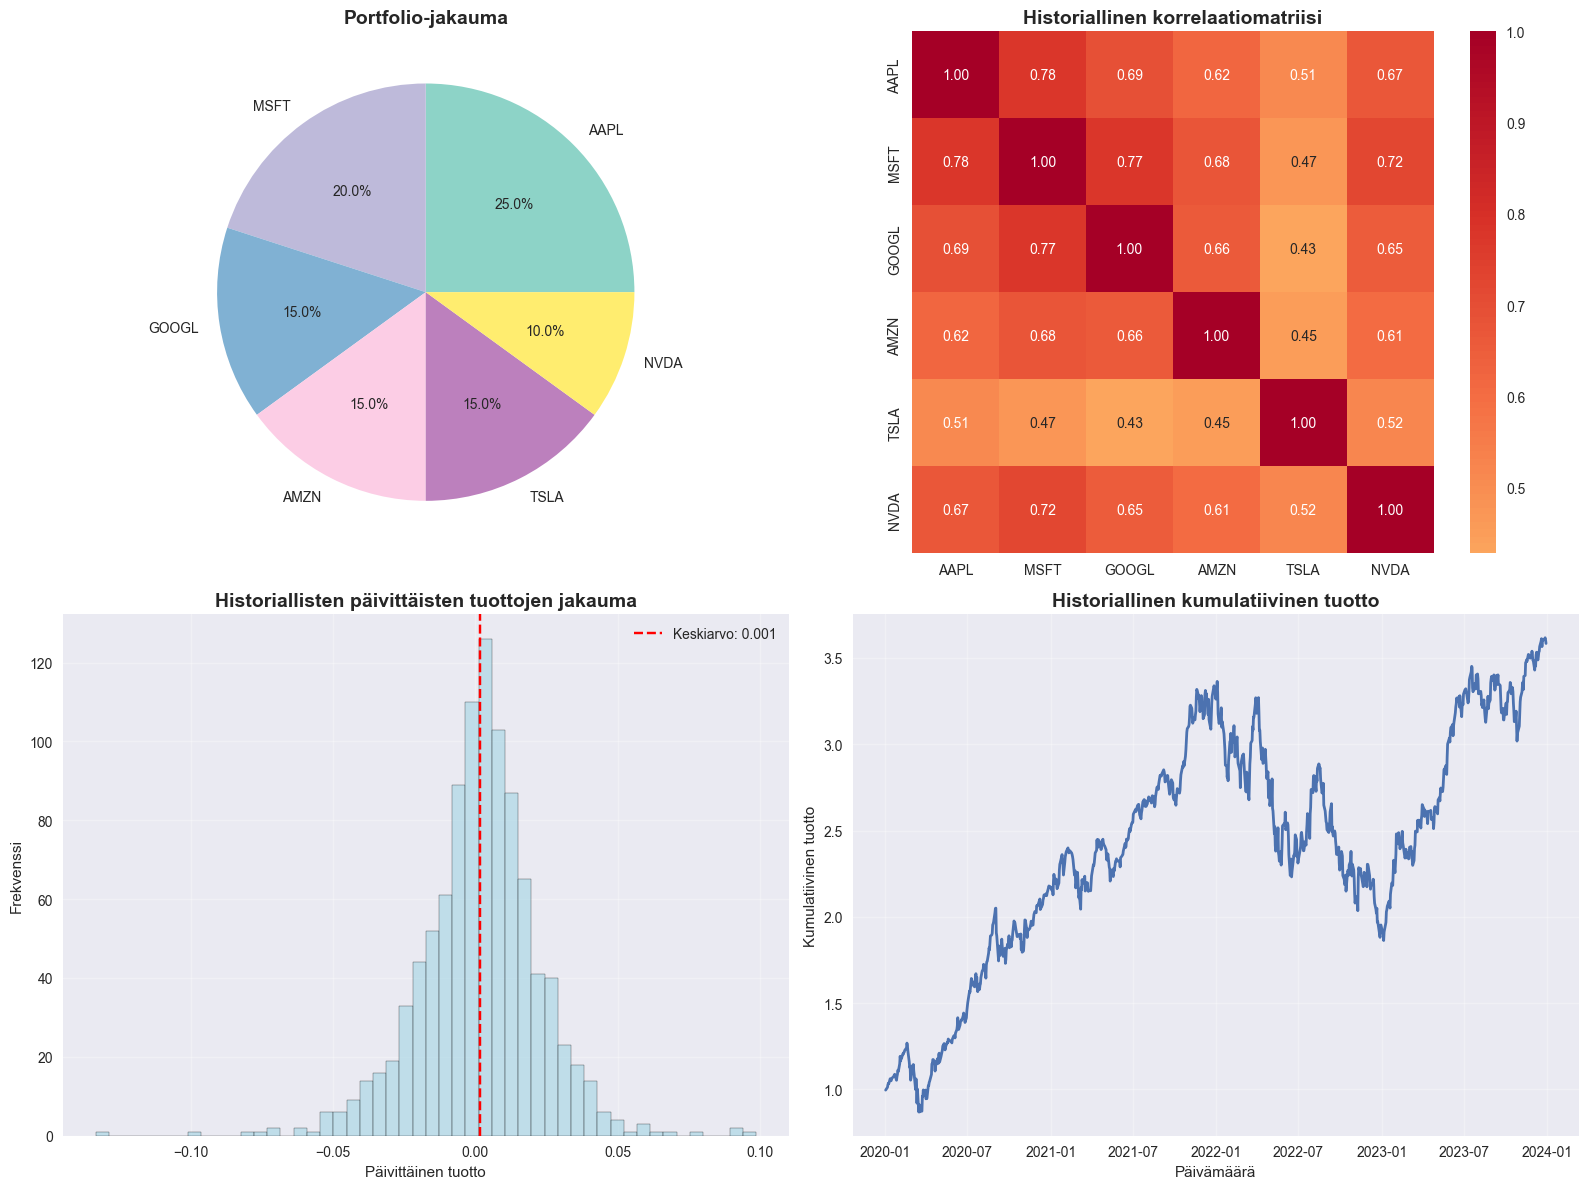

In [14]:
# 2. Historiallinen analyysi
print("\n🔄 VAIHE 2: Historiallinen analyysi")
try:
    historical_metrics = stress_tester.historical_portfolio_metrics()
    
    # perusvisualisoinnit
    stress_tester.create_basic_visualizations()
    
except Exception as e:
    print(f"❌ Virhe historiallisessa analyysissä: {e}")


🔄 VAIHE 3: Monte Carlo -simulaatio (normaali)

🎲 MONTE CARLO SIMULAATIO:
   Simulaatioita: 25,000
   Aikahoristontti: 252 päivää
   Jakauma: normal
--------------------------------------------------
Simulaatio 0/25,000
Simulaatio 2,000/25,000
Simulaatio 4,000/25,000
Simulaatio 6,000/25,000
Simulaatio 8,000/25,000
Simulaatio 10,000/25,000
Simulaatio 12,000/25,000
Simulaatio 14,000/25,000
Simulaatio 16,000/25,000
Simulaatio 18,000/25,000
Simulaatio 20,000/25,000
Simulaatio 22,000/25,000
Simulaatio 24,000/25,000

📊 SIMULAATIOTULOKSET:
--------------------------------------------------
Alkuarvo: 1,000,000€
Keskimääräinen loppuarvo: 1,460,623€
Mediaani loppuarvo: 1,377,288€
Odotettu tuotto: 46.1%

💰 VALUE AT RISK (VaR):
VaR 95%: 205,301€ (20.5%) - Arvo: 794,699€
VaR 99%: 368,795€ (36.9%) - Arvo: 631,205€
VaR 99.9%: 502,036€ (50.2%) - Arvo: 497,964€

🔻 EXPECTED SHORTFALL (CVaR):
CVaR 95%: 302,477€ (30.2%) - Keskiarvo: 697,523€
CVaR 99%: 428,842€ (42.9%) - Keskiarvo: 571,158€
CVaR 99.9%: 531

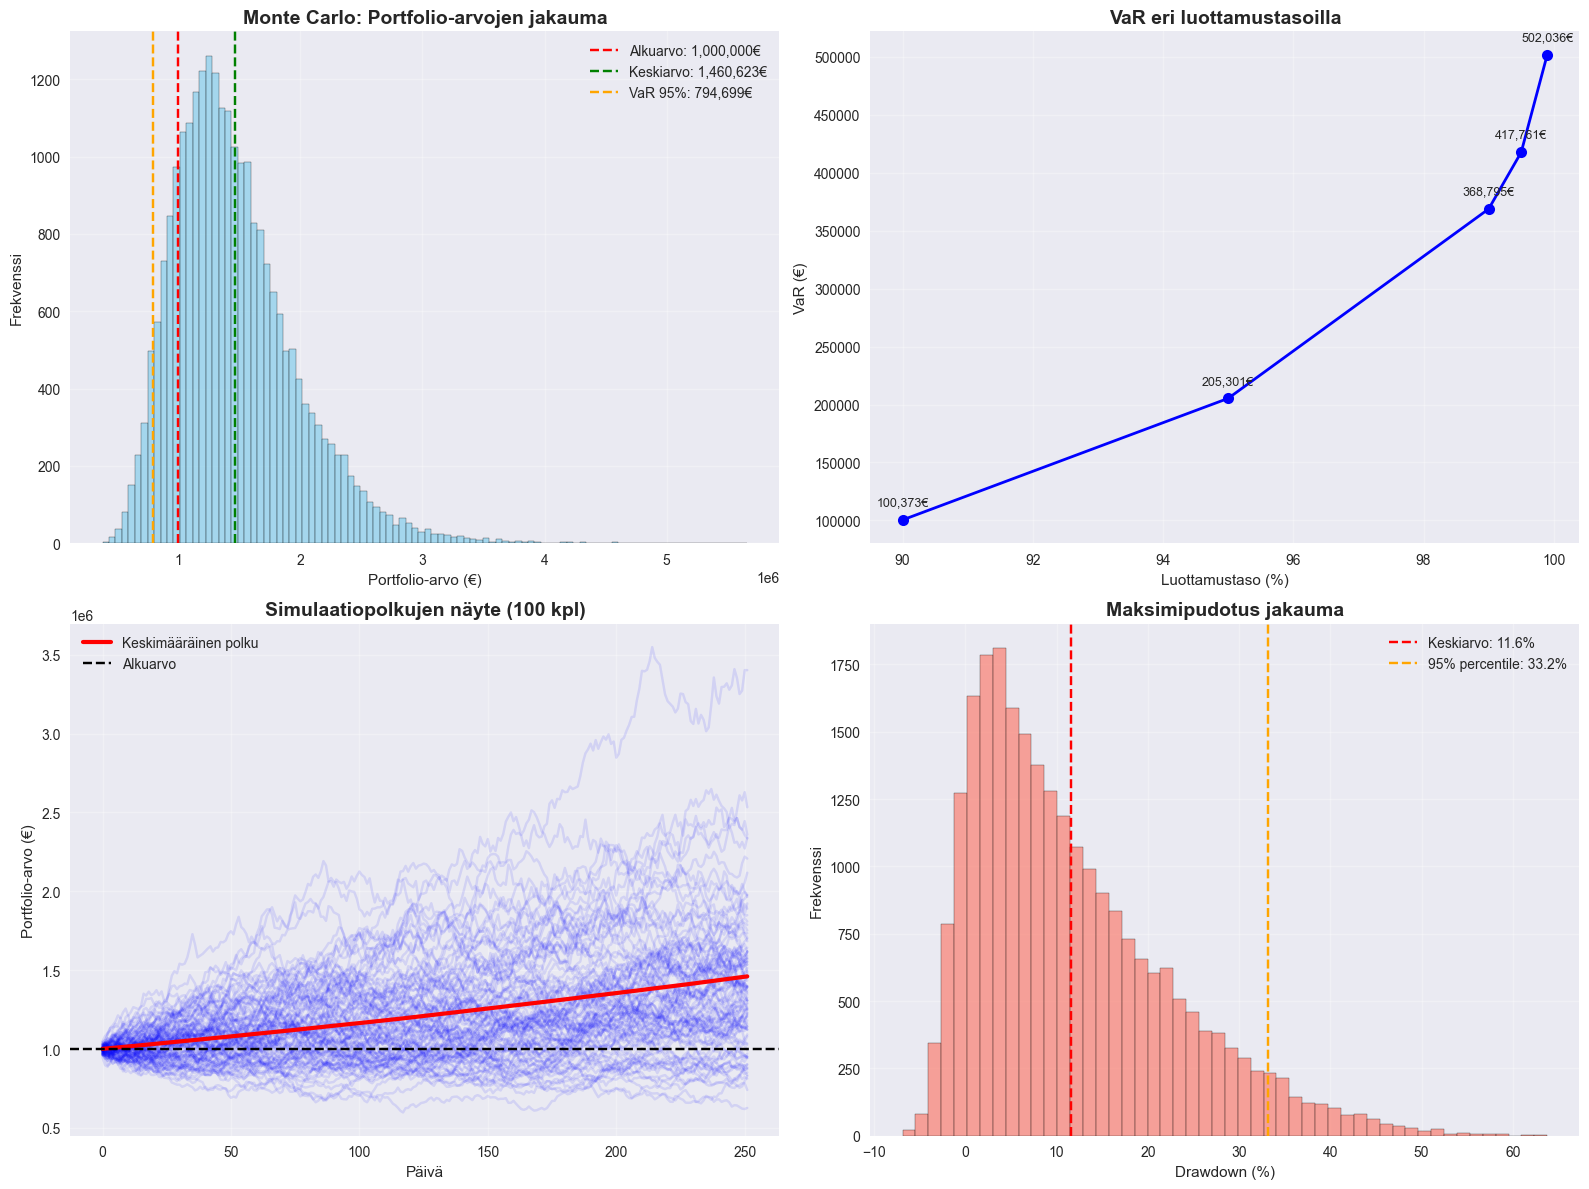

In [15]:
# 3. Monte Carlo -simulaatio (normaalijakauma)
print("\n🔄 VAIHE 3: Monte Carlo -simulaatio (normaali)")
try:
    mc_results_normal = stress_tester.monte_carlo_simulation(
        n_simulations=25000,    # Muokkaa tarvittaessa (enemmän = tarkempi mutta hitaampi)
        time_horizon=252,       # 1 vuosi (252 kaupankäyntipäivää)
        distribution='normal'
    )
    
    # Luodaan Monte Carlo visualisoinnit
    stress_tester.create_monte_carlo_visualizations()
    
except Exception as e:
    print(f"❌ Virhe Monte Carlo simulaatiossa: {e}")

In [16]:
# 4. Monte Carlo -simulaatio (t-jakauma, raskaammilla hännillä)
print("\n🔄 VAIHE 4: Monte Carlo -simulaatio (t-jakauma)")
try:
    mc_results_t = stress_tester.monte_carlo_simulation(
        n_simulations=25000,
        time_horizon=252,
        distribution='t_distribution'
    )
    
    # Vertaillaan jakaumia
    print("\n📊 JAKAUMA-ANALYYSI:")
    print("-" * 30)
    normal_var95 = np.percentile(mc_results_normal['final_values'], 5)
    t_var95 = np.percentile(mc_results_t['final_values'], 5)
    normal_loss = stress_tester.portfolio_value - normal_var95
    t_loss = stress_tester.portfolio_value - t_var95
    
    print(f"Normaalijakauma VaR 95%: {normal_loss:,.0f}€")
    print(f"t-jakauma VaR 95%: {t_loss:,.0f}€")
    print(f"Ero (fat tails): {t_loss - normal_loss:+,.0f}€")
    
    if t_loss > normal_loss * 1.2:
        print("⚠️ t-jakauma paljastaa merkittävästi korkeamman häntäriskin!")
    
except Exception as e:
    print(f"❌ Virhe t-jakauma simulaatiossa: {e}")


🔄 VAIHE 4: Monte Carlo -simulaatio (t-jakauma)

🎲 MONTE CARLO SIMULAATIO:
   Simulaatioita: 25,000
   Aikahoristontti: 252 päivää
   Jakauma: t_distribution
--------------------------------------------------
Simulaatio 0/25,000
Simulaatio 2,000/25,000
Simulaatio 4,000/25,000
Simulaatio 6,000/25,000
Simulaatio 8,000/25,000
Simulaatio 10,000/25,000
Simulaatio 12,000/25,000
Simulaatio 14,000/25,000
Simulaatio 16,000/25,000
Simulaatio 18,000/25,000
Simulaatio 20,000/25,000
Simulaatio 22,000/25,000
Simulaatio 24,000/25,000

📊 SIMULAATIOTULOKSET:
--------------------------------------------------
Alkuarvo: 1,000,000€
Keskimääräinen loppuarvo: 999,333€
Mediaani loppuarvo: 984,182€
Odotettu tuotto: -0.1%

💰 VALUE AT RISK (VaR):
VaR 95%: 262,261€ (26.2%) - Arvo: 737,739€
VaR 99%: 349,698€ (35.0%) - Arvo: 650,302€
VaR 99.9%: 431,741€ (43.2%) - Arvo: 568,259€

🔻 EXPECTED SHORTFALL (CVaR):
CVaR 95%: 315,624€ (31.6%) - Keskiarvo: 684,376€
CVaR 99%: 385,894€ (38.6%) - Keskiarvo: 614,106€
CVaR 99.9%


🔄 VAIHE 5: Stressiskenaario-analyysi

⚡ STRESSISKENAARIO-ANALYYSI:
--------------------------------------------------

📊 Skenaario: Black Monday 1987
   Keskimääräinen tappio: 180,647€ (18.1%)
   VaR 95%: 411,265€ (41.1%)
   VaR 99%: 475,006€ (47.5%)
   Worst case: 595,053€ (59.5%)

📊 Skenaario: Dotcom Crash 2000
   Keskimääräinen tappio: 113,640€ (11.4%)
   VaR 95%: 334,673€ (33.5%)
   VaR 99%: 408,538€ (40.9%)
   Worst case: 521,766€ (52.2%)

📊 Skenaario: Financial Crisis 2008
   Keskimääräinen tappio: 141,075€ (14.1%)
   VaR 95%: 376,111€ (37.6%)
   VaR 99%: 445,843€ (44.6%)
   Worst case: 565,149€ (56.5%)

📊 Skenaario: COVID-19 Crash 2020
   Keskimääräinen tappio: 116,626€ (11.7%)
   VaR 95%: 344,610€ (34.5%)
   VaR 99%: 414,379€ (41.4%)
   Worst case: 552,358€ (55.2%)

📊 Skenaario: Flash Crash 2010
   Keskimääräinen tappio: 77,878€ (7.8%)
   VaR 95%: 292,324€ (29.2%)
   VaR 99%: 350,407€ (35.0%)
   Worst case: 427,288€ (42.7%)

📊 Skenaario: Mild Recession
   Keskimääräinen tappio

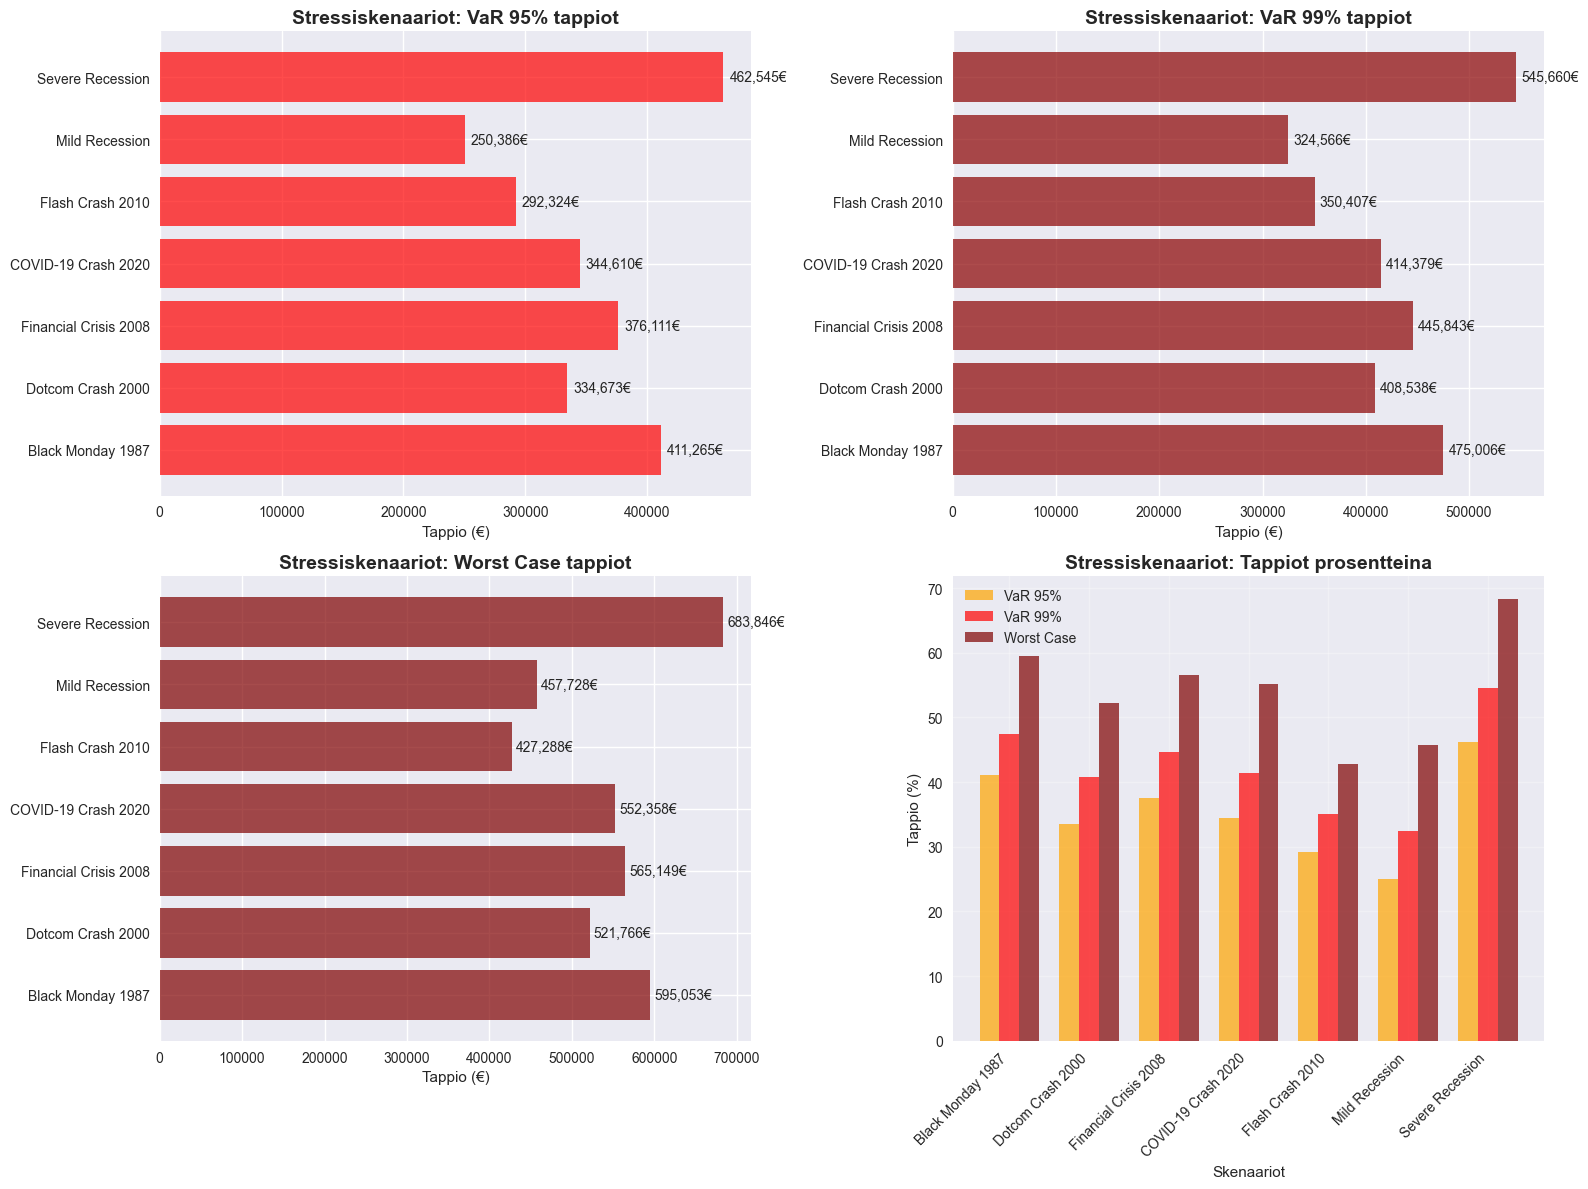

In [17]:
# 5. Stressiskenaariot
print("\n🔄 VAIHE 5: Stressiskenaario-analyysi")
try:
    stress_scenarios_results = stress_tester.stress_scenarios()
    
    # Luodaan visualisoinnit
    stress_tester.create_stress_visualizations()
    
except Exception as e:
    print(f"❌ Virhe stressitesteissä: {e}")

In [18]:
# 6. Loppuraportti
print("\n🔄 VAIHE 6: Riskiraportti")
try:
    risk_report = stress_tester.generate_risk_report()
    
    print("\n✅ STRESS-ANALYYSI VALMIS!")
    print("\n🎯 YHTEENVETO:")
    print("-" * 40)
    
    if 'var_95' in risk_report:
        print(f"• VaR 95% (1 vuosi): {risk_report['var_95']:,.0f}€")
    if 'var_99' in risk_report:
        print(f"• VaR 99% (1 vuosi): {risk_report['var_99']:,.0f}€")
    
    print(f"\n📊 Analyysi sisältää:")
    print("✓ Historiallinen portfolio-analyysi")
    print("✓ Monte Carlo simulaatio (normaali- ja t-jakauma)")
    print("✓ Stressiskenaariot historiallisten kriisien pohjalta")
    print("✓ Kattavat visualisoinnit")
    print("✓ Riskiraportti ja suositukset")
    
except Exception as e:
    print(f"❌ Virhe riskiraportissa: {e}")


🔄 VAIHE 6: Riskiraportti

📋 MONTE CARLO STRESS TESTING - RISKIRAPORTTI

🎯 PORTFOLIO-YLEISKATSAUS:
Portfolio-arvo: 1,000,000€
Osakkeet: AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA
Painotus: 25.0%, 20.0%, 15.0%, 15.0%, 15.0%, 10.0%

📊 MONTE CARLO TULOKSET (25,000 simulaatiota):
Aikahoristontti: 252 päivää
Odotettu tuotto: -0.1%
Volatiliteetti: 17.6%

💰 RISKIMITTARIT:
VaR 95% (1 vuosi): 262,261€ (26.2%)
VaR 99% (1 vuosi): 349,698€ (35.0%)
Expected Shortfall 95%: 315,624€ (31.6%)

⚡ STRESSITESTI-YHTEENVETO:
--------------------------------------------------
Black Monday 1987        :  411,265€ ( 41.1%)
Dotcom Crash 2000        :  334,673€ ( 33.5%)
Financial Crisis 2008    :  376,111€ ( 37.6%)
COVID-19 Crash 2020      :  344,610€ ( 34.5%)
Flash Crash 2010         :  292,324€ ( 29.2%)
Mild Recession           :  250,386€ ( 25.0%)
Severe Recession         :  462,545€ ( 46.3%)

🎯 SUOSITUKSET:
🔴 KORKEA RISKI: Portfolio on erittäin riskialtis
   → Harkitse hajautuksen lisäämistä
   → Vähennä riski-omai

In [19]:
# Mukautetut testit ja analyysit

print("\n🔬 MUKAUTETUT ANALYYSIT:")
print("-" * 30)

# Lisäanalyysit:

# 1. Eri aikahorisonttien vertailu
print("\n1. Eri aikahorisonttien VaR-vertailu:")
for horizon in [30, 60, 126, 252]:  # 1kk, 2kk, 6kk, 1v
    mc_temp = stress_tester.monte_carlo_simulation(
        n_simulations=10000,
        time_horizon=horizon,
        distribution='normal'
    )
    var_95 = stress_tester.portfolio_value - np.percentile(mc_temp['final_values'], 5)
    print(f"   {horizon:3d} päivää: {var_95:8,.0f}€ ({var_95/stress_tester.portfolio_value*100:5.1f}%)")

# 2. Eri simulaatiomäärien vertailu (konvergenssi)
print("\n2. Simulaatiomäärien konvergenssi:")
for n_sims in [1000, 5000, 10000, 25000]:
    mc_temp = stress_tester.monte_carlo_simulation(
        n_simulations=n_sims,
        time_horizon=252,
        distribution='normal'
    )
    var_95 = stress_tester.portfolio_value - np.percentile(mc_temp['final_values'], 5)
    print(f"   {n_sims:5d} sim: {var_95:8,.0f}€")

print("\n🎊 Analyysi valmis!")


🔬 MUKAUTETUT ANALYYSIT:
------------------------------

1. Eri aikahorisonttien VaR-vertailu:

🎲 MONTE CARLO SIMULAATIO:
   Simulaatioita: 10,000
   Aikahoristontti: 30 päivää
   Jakauma: normal
--------------------------------------------------
Simulaatio 0/10,000
Simulaatio 2,000/10,000
Simulaatio 4,000/10,000
Simulaatio 6,000/10,000
Simulaatio 8,000/10,000

📊 SIMULAATIOTULOKSET:
--------------------------------------------------
Alkuarvo: 1,000,000€
Keskimääräinen loppuarvo: 1,046,026€
Mediaani loppuarvo: 1,037,490€
Odotettu tuotto: 4.6%

💰 VALUE AT RISK (VaR):
VaR 95%: 142,755€ (14.3%) - Arvo: 857,245€
VaR 99%: 205,994€ (20.6%) - Arvo: 794,006€
VaR 99.9%: 264,540€ (26.5%) - Arvo: 735,460€

🔻 EXPECTED SHORTFALL (CVaR):
CVaR 95%: 180,933€ (18.1%) - Keskiarvo: 819,067€
CVaR 99%: 235,623€ (23.6%) - Keskiarvo: 764,377€
CVaR 99.9%: 283,970€ (28.4%) - Keskiarvo: 716,030€

📉 MAKSIMIPUDOTUS:
Suurin mahdollinen tappio matkan varrella: 317,694€ (31.8%)

🎯 TODENNÄKÖISYYDET:
Positiivinen tuott